# Semisupervised Intent Classification using GAN-BERT on Engine Design Dataset:

##Introduction to GAN-BERT:

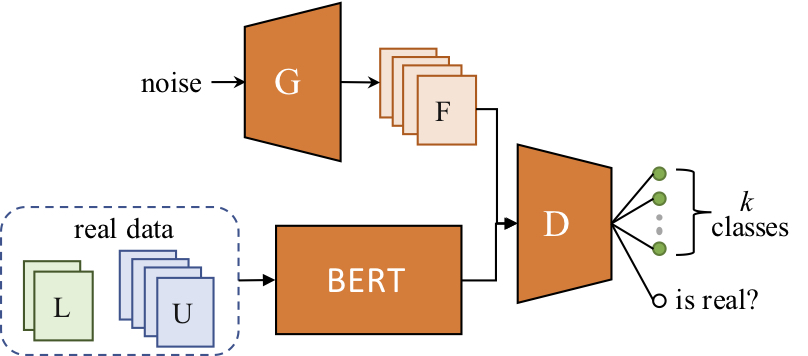

GAN-BERT combines the power of BERT and SS-GAN. In this notebook, we are using it for intent classification. The generator produces "fake" examples by taking the input of a 100-dimensional noise vector drawn from Gaussian Distribution. The discriminator is an MLP on top of BERT which receives the input vector either a fake vector generated by the generator or the vector from the real data generated by BERT. The final layer of the discriminator is a softmax layer which outputs the k+1 dimension vector of logits, where k is the number of classes in the dataset. Here, the real data is divided into 2, they are labelled (L) and unlabelled (U) data.

The discriminator aims to classify whether the input is a real instance or not. If it predicts the input as a real instance, then it has to predict which class the input belongs to.

The training process tries to optimize two competing losses, they are discriminator loss and generator loss. The discriminator loss is the summation of 2 other losses: supervised and unsupervised loss. Supervised loss measures the error in assigning the wrong class to a real example among the original k categories, while unsupervised loss measures the error in incorrectly recognizing a real (unlabeled) example as fake and not recognizing a fake example. The generator loss is also the result of summation from 2 other losses: feature matching and unsupervised loss. Feature matching loss aims to make sure that the generator should produce examples whose intermediate representations provided in input to the discriminator are very similar to the real ones, while unsupervised loss measures the error induced by fake examples correctly identified by the discriminator.

During training, the samples in each class are replicated in the factor of log(2|U|/|L|), to guarantees the presence of some labelled instances in each batch to avoid divergences due to the unsupervised component of the adversarial training. During inference process, the generator is discarded from the architecture while retaining the rest.

## Mounting the drive:

In [ ]:
%cd "/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT"

/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT


## Data Preparation:

In [ ]:
# Importing all the modules
import os
import csv
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
%matplotlib inline

In [ ]:
# Reading the base line file which has 272 labeled data points
df = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/chat_messages.csv',na_values=' ')
df = df[['body', 'intent']]
df.head(2)

,body,intent
0,Hi piston! My crankshaft depends on your bore ...,Providing information
1,thank you!,Accepting information/Affirmation


In [ ]:
# Unique intents 
df['intent'].unique()

array(['Providing information', 'Accepting information/Affirmation',
       'Enquiring information', 'Understanding the dependency',
       'Exploration',
       'Monitoring the system objectives and their tradeoff',
       'Requesting for help', 'Suggesting information', nan, 'NAN'],
      dtype=object)

##### Takeaway: We have identified 9 unique intents for this experimental notebook. We plan to remove the NAN/ None of the above intent as it is not contributing much to the analysis.


In [ ]:
# Dropping the NAN/None of the above intent
df.drop(index = df.index[(df['intent']=='NAN')], axis=0, inplace = True)
df['intent'].unique()

array(['Providing information', 'Accepting information/Affirmation',
       'Enquiring information', 'Understanding the dependency',
       'Exploration',
       'Monitoring the system objectives and their tradeoff',
       'Requesting for help', 'Suggesting information', nan], dtype=object)

In [ ]:
# Checking out the final labeled and unlabeled instances 
total = len(df['intent'])
unlabeled_instances = df['intent'].isnull().sum()
labeled_instances = total - unlabeled_instances
print('Labeled instances: ', labeled_instances, ' and Unlabeled instances: ', unlabeled_instances)

Labeled instances:  7405  and Unlabeled instances:  272


In [ ]:
# Filling out "UNK_UNK" for unlabeled instances
df = df.fillna("UNK_UNK")
df['intent'].unique()

array(['Providing information', 'Accepting information/Affirmation',
       'Enquiring information', 'Understanding the dependency',
       'Exploration',
       'Monitoring the system objectives and their tradeoff',
       'Requesting for help', 'Suggesting information', 'UNK_UNK'],
      dtype=object)

In [ ]:
# Defining the unlabeled instances dataframe
df_unlabeled = df[df['intent']=='UNK_UNK']
df_unlabeled

NameError: ignored

In [ ]:
# Defining the labeled instances dataframe
df_labeled = df[df['intent']!='UNK_UNK']
df_labeled

,body,intent
0,Hi piston! My crankshaft depends on your bore ...,Providing information
1,thank you!,Accepting information/Affirmation
2,How low can you go on the piston bore diameter?,Enquiring information
3,"all my fos values are in the hundreds, i suspe...",Understanding the dependency
4,Hi flywheel! My crankshaft depends on your fly...,Providing information
...,...,...
517,What's keeping the piston bore from being mini...,Understanding the dependency
520,Try and minimize your mass but keep fos above 2,Suggesting information
522,Hey what mass are you getting?,Enquiring information
523,"cool, can you get your mass any lower?",Suggesting information


In [ ]:
# Renaming columns to suitable names
df_labeled.rename(columns = {'intent': 'intent', 'body':'text'}, inplace = True)
df_unlabeled.rename(columns = {'intent': 'intent', 'body':'text'}, inplace = True)
df_labeled.head(2), df_unlabeled.head(2)

(                                                text                             intent
 0  Hi piston! My crankshaft depends on your bore ...              Providing information
 1                                         thank you!  Accepting information/Affirmation,
                                              text   intent
 56            we have excellent quality right now  UNK_UNK
 57  Have you broadcasted your most recent design?  UNK_UNK)

In [ ]:
# Double checking the intents of labeled dataset
df_labeled.intent.unique()

array(['Providing information', 'Accepting information/Affirmation',
       'Enquiring information', 'Understanding the dependency',
       'Exploration',
       'Monitoring the system objectives and their tradeoff',
       'Requesting for help', 'Suggesting information'], dtype=object)

In [ ]:
# Mapping intents to shorter abbreviations
intents = {'Providing information': 'Prov_Info', 'Accepting information/Affirmation' : 'Acc_Info',
       'Enquiring information' : 'Enq_Info', 'Understanding the dependency' : 'Underst_Dep',
       'Exploration' : 'Explore_Param', 'Monitoring the system objectives and their tradeoff':'Monitoring_Obj', 
       'Requesting for help': 'Request_Help', 'Suggesting information':'Sugg_Info'}

In [ ]:
# Cleaning the labeled dataset
df_labeled["intents"] = df_labeled["intent"].map(intents)
df_labeled = df_labeled[['intents', 'text', 'intent']]
del df_labeled['intent']
df_labeled.reset_index(drop=True, inplace=True)
df_labeled.head(2)

,intents,text
0,Prov_Info,Hi piston! My crankshaft depends on your bore ...
1,Acc_Info,thank you!


In [ ]:
# Cleaning the unlabeled dataset
df_unlabeled["intents"] = df_unlabeled["intent"]
df_unlabeled = df_unlabeled[['intents', 'text', 'intent']]
del df_unlabeled['intent']
df_unlabeled.reset_index(drop=True, inplace=True)
df_unlabeled.head(2)

,intents,text
0,UNK_UNK,we have excellent quality right now
1,UNK_UNK,Have you broadcasted your most recent design?


In [ ]:
# Double checking the intents of labeled and unlabeled dataset
df_labeled['intents'].unique(), df_unlabeled['intents'].unique()

(array(['Prov_Info', 'Acc_Info', 'Enq_Info', 'Underst_Dep',
        'Explore_Param', 'Monitoring_Obj', 'Request_Help', 'Sugg_Info'],
       dtype=object), array(['UNK_UNK'], dtype=object))

In [ ]:
def split_labeled(df_labeled, df_unlabeled, labeled_prop, unlabeled_prop):
  '''
  This function splits the labeled and unlabeled dataset into four files which are listed as follows:
  1. labeled.tsv: Contains all the labeled data points
  2. unlabeled.tsv: Contains all the unlabeled data points
  3. test.tsv: Contains the test utterances
  4. test_OOS.tsv: Contains the test out-of-space utterances
  For each intent, there are 210 training utterances, and 62 testing utterances.
  '''
  
  df_labeled = df_labeled.sample(frac=1).reset_index(drop=True)
  df_unlabeled = df_unlabeled.sample(frac=1).reset_index(drop=True)

  with open(f'/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/labeled.tsv','a+') as f_out:
      f_out.write('fine_label utterance'+'\n')
      for i in range(len(df_labeled[:labeled_prop])):
          line = ' '.join([str(df_labeled.loc[i,'intents']), str(df_labeled.loc[i,'text'])])
          f_out.write(line+'\n')

  with open(f'/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/unlabeled.tsv','a+') as f_out:
      f_out.write('fine_label utterance'+'\n')
      for i in range(len(df_unlabeled[:unlabeled_prop])):
          line = ' '.join(['UNK_UNK', str(df_unlabeled.loc[i,'text'])])
          f_out.write(line+'\n')

  with open(f'/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/test_OOS.tsv','a+') as f_out:
      f_out.write('fine_label utterance'+'\n')
      for i in range(len(df_unlabeled[unlabeled_prop+1:])):
          line = ' '.join(['OOS', str(df_unlabeled.loc[i,'text'])])
          f_out.write(line+'\n')

  test_data = df_labeled[labeled_prop+1 :]
  test_data = test_data.reset_index(drop=True)
  with open(f'/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/test.tsv','a+') as f_out:
    f_out.write('fine_label utterance'+'\n')
    for i in range(len(test_data)):
      line = ' '.join([str(test_data.loc[i,'intents']), str(test_data.loc[i,'text'])])
      f_out.write(line+'\n')

split_labeled(df_labeled,df_unlabeled,210,5000)

## Installing Dependencies:
1. https://github.com/guillaumegenthial/tf_metrics.git
2. tensorflow-gpu version - 1.14.0
3. gast version - 0.2.2

In [ ]:
!pip install git+https://github.com/guillaumegenthial/tf_metrics.git
!pip install tensorflow-gpu==1.14.0
!pip install gast==0.2.2

  Cloning https://github.com/guillaumegenthial/tf_metrics.git to /tmp/pip-req-build-svwm4_iw
  Running command git clone -q https://github.com/guillaumegenthial/tf_metrics.git /tmp/pip-req-build-svwm4_iw
  Created wheel for tf-metrics: filename=tf_metrics-0.0.1-cp37-none-any.whl size=7692 sha256=21043ba2205057481786eb81d96eb62a6f36db62bb7e5bcfaa11be5914cf7cc2
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0py_6s8/wheels/da/6c/c8/663ef339a0666590dc53bd13bab86643a1f9c35b26742d7876
Successfully built tf-metrics


## Documentation:
### Code files: 
1. ganbert.py
2. data_processors.py
3. modeling.py
4. optimization.py
5. tokenization.py

### Script files: 
1. run_experiement.sh: For GAN-BERT model
2. run_bert.sh: For BERT model


## Training using GAN-BERT:

Instructions: Params to be adjusted:
1. label_rate (If |L|/|U| > 1 then 1/2 else |L|/2|U|) 
2. data_dir
3. output_dir
4. learning rate
5. epochs

#### Run 1: (Final Parameters)
Hyperparameters used: (do_train=true, do_eval=true,do_predict=false, and pred_OOS=false)
1. learning rate = 2e-5
2. label_rate = 0.02
3. max_seq_length = 64 
4. train_batch_size = 64
5. warmup_proportion = 0.1
6. epochs = 10
7. task_name = general


In [ ]:
!bash /content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/run_experiment.sh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
#!bash /content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/run_experiment_1.sh

Streaming output truncated to the last 5000 lines.
I0429 11:47:53.537990 140080249415552 tpu_estimator.py:2159] global_step/sec: 0.675102
INFO:tensorflow:examples/sec: 43.2065
I0429 11:47:53.538182 140080249415552 tpu_estimator.py:2160] examples/sec: 43.2065
INFO:tensorflow:d_loss = 1.4271437, g_loss = 0.51341283, per_example_loss = [0.00515264 0.0006851  0.0049408  0.00122948 0.00013541 0.00025972
 0.0004467  0.00108172 0.00043323 0.0004523  0.00107195 0.00034779
 0.00203866 0.00027236] (1.493 sec)
I0429 11:47:55.029855 140080249415552 basic_session_run_hooks.py:260] d_loss = 1.4271437, g_loss = 0.51341283, per_example_loss = [0.00515264 0.0006851  0.0049408  0.00122948 0.00013541 0.00025972
 0.0004467  0.00108172 0.00043323 0.0004523  0.00107195 0.00034779
 0.00203866 0.00027236] (1.493 sec)
INFO:tensorflow:global_step/sec: 0.669745
I0429 11:47:55.031114 140080249415552 tpu_estimator.py:2159] global_step/sec: 0.669745
INFO:tensorflow:examples/sec: 42.8637
I0429 11:47:55.031336 140080

#### Run 2:
Hyperparameters used: (do_train=true, do_eval=true,do_predict=false, and pred_OOS=false)
1. learning rate = 1e-5
2. label_rate = 0.05
3. max_seq_length = 64 
4. train_batch_size = 64
5. warmup_proportion = 0.1
6. epochs = 7
7. task_name = general

In [ ]:
#!bash /content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/run_experiment_2.sh

Streaming output truncated to the last 5000 lines.
I0429 12:11:43.250548 139707402647424 tpu_estimator.py:2160] examples/sec: 42.8872
INFO:tensorflow:d_loss = 5.331439, g_loss = 0.36597374, per_example_loss = [1.1175864 1.6798389 4.9321356 4.572541  1.5135803] (1.477 sec)
I0429 12:11:44.726401 139707402647424 basic_session_run_hooks.py:260] d_loss = 5.331439, g_loss = 0.36597374, per_example_loss = [1.1175864 1.6798389 4.9321356 4.572541  1.5135803] (1.477 sec)
INFO:tensorflow:global_step/sec: 0.676839
I0429 12:11:44.727813 139707402647424 tpu_estimator.py:2159] global_step/sec: 0.676839
INFO:tensorflow:examples/sec: 43.3177
I0429 12:11:44.727988 139707402647424 tpu_estimator.py:2160] examples/sec: 43.3177
INFO:tensorflow:d_loss = 4.6060243, g_loss = 0.3673945, per_example_loss = [3.527197   0.8002245  3.9063292  0.90860736 1.1758006  1.9225254 ] (1.489 sec)
I0429 12:11:46.214954 139707402647424 basic_session_run_hooks.py:260] d_loss = 4.6060243, g_loss = 0.3673945, per_example_loss = 

## Prediction of label for In-Space Samples:


---


With:
do_train=false, do_eval=false,do_predict=true, and pred_OOS=false



In [ ]:
!bash /content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/run_ganbert.sh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Inference:

******** Final Hyperparameters used for training: ********
1. learning rate = 2e-5
2. label_rate = 0.02
3. max_seq_length = 64 
4. train_batch_size = 64
5. warmup_proportion = 0.1
6. epochs = 12
7. task_name = general

Model converged at d_loss = 1.0385413 and g_loss = 0.37207836


******** Final Performance Parameters: ********

1. eval_accuracy = 0.704918
2. eval_f1_macro = 0.27156514
3. eval_f1_micro = 0.704918
4. eval_loss = 2.140911
5. eval_precision = 0.704918
6. eval_recall = 0.704918
7. global_step = 945
8. loss = 3.2304316

In [ ]:
df_groundtruth = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/test.tsv',sep='\t')
df_pred = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/ganbert_output_model/train/test_results.tsv',sep='\t',header=None)

In [ ]:
df_groundtruth['intents'] = df_groundtruth['fine_label utterance'].apply(lambda x: x.split(" ")[0])

In [ ]:
# This label list is printed during the inference process. You can directly copy the list from there
label_list = ['UNK_UNK', 'Prov_Info', 'Monitoring_Obj', 'Underst_Dep', 'Enq_Info', 'Acc_Info', 'Sugg_Info', 'Explore_Param', 'Request_Help']
df_pred.columns = label_list 

In [ ]:
df_pred['intents'] = df_pred.apply(lambda x: np.argmax(x),axis=1).apply(lambda x: label_list[x])

In [ ]:
df_pred.sample(20)

,UNK_UNK,Prov_Info,Monitoring_Obj,Underst_Dep,Enq_Info,Acc_Info,Sugg_Info,Explore_Param,Request_Help,intents
49,0.000020,0.000005,0.000082,0.000540,0.999213,0.000060,0.000010,0.000066,0.000005,Enq_Info
52,0.000011,0.999905,0.000018,0.000005,0.000011,0.000010,0.000003,0.000035,0.000003,Prov_Info
46,0.000020,0.000005,0.000082,0.000540,0.999213,0.000060,0.000010,0.000066,0.000005,Enq_Info
24,0.000046,0.000097,0.000075,0.000008,0.000028,0.999532,0.000057,0.000023,0.000134,Acc_Info
16,0.000012,0.999842,0.000019,0.000005,0.000008,0.000061,0.000004,0.000041,0.000007,Prov_Info
40,0.000020,0.000006,0.000065,0.000163,0.999519,0.000137,0.000011,0.000071,0.000009,Enq_Info
35,0.000900,0.000355,0.002108,0.001257,0.055434,0.925260,0.013015,0.001214,0.000457,Acc_Info
45,0.000020,0.000005,0.000082,0.000540,0.999213,0.000060,0.000010,0.000066,0.000005,Enq_Info
11,0.000009,0.999923,0.000016,0.000004,0.000007,0.000009,0.000003,0.000025,0.000003,Prov_Info
0,0.000039,0.000042,0.000041,0.000011,0.000037,0.999711,0.000041,0.000028,0.000051,Acc_Info


In [ ]:
df_groundtruth.loc[[13,36,53]]

,fine_label utterance,intents
13,Enq_Info Do you have a value for the bore diam...,Enq_Info
36,Enq_Info your mass is 25.98?,Enq_Info
53,Prov_Info I re-simulated with the others' upda...,Prov_Info


In [ ]:
print(classification_report(df_groundtruth['intents'], df_pred['intents']))

                precision    recall  f1-score   support

      Acc_Info       0.13      0.22      0.17         9
      Enq_Info       0.13      0.15      0.14        13
 Explore_Param       0.00      0.00      0.00         3
Monitoring_Obj       0.00      0.00      0.00         2
     Prov_Info       0.40      0.45      0.43        22
  Request_Help       0.00      0.00      0.00         2
     Sugg_Info       0.00      0.00      0.00         7
   Underst_Dep       0.00      0.00      0.00         3

      accuracy                           0.23        61
     macro avg       0.08      0.10      0.09        61
  weighted avg       0.19      0.23      0.21        61



## Prediction of label for Out-of-Space Samples:

With:
do_train=false, do_eval=true,do_predict=true, and pred_OOS=true

Hyperparameters used: (do_train=false, do_eval=false,do_predict=true, and pred_OOS=true)
1. learning rate = 2e-5
2. label_rate = 0.02
3. max_seq_length = 64 
4. train_batch_size = 64
5. warmup_proportion = 0.1
6. epochs = 7
7. task_name = general

In [ ]:
!bash /content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/run_ganbert_OOS.sh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Inference:

In [ ]:
df_pred_OOS = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/ganbert_output_model/predict_OOS/OOS_test_results.tsv',sep='\t',header=None)
# This label list is printed during the inference process. You can directly copy the list from there
label_list = ['OOS', 'UNK_UNK', 'Prov_Info', 'Monitoring_Obj', 'Underst_Dep', 'Enq_Info', 'Acc_Info', 'Sugg_Info', 'Explore_Param', 'Request_Help']
df_pred_OOS.columns = label_list 
df_pred_OOS['intents'] = df_pred_OOS.apply(lambda x: np.argmax(x),axis=1).apply(lambda x: label_list[x])
df_pred_OOS

,OOS,UNK_UNK,Prov_Info,Monitoring_Obj,Underst_Dep,Enq_Info,Acc_Info,Sugg_Info,Explore_Param,Request_Help,intents
0,0.104513,0.142429,0.075685,0.059506,0.010008,0.071576,0.163459,0.091623,0.190962,0.090238,Explore_Param
1,0.104513,0.142429,0.075685,0.059506,0.010008,0.071576,0.163459,0.091623,0.190962,0.090238,Explore_Param
2,0.104513,0.142429,0.075685,0.059506,0.010008,0.071576,0.163459,0.091623,0.190962,0.090238,Explore_Param
3,0.104513,0.142429,0.075685,0.059506,0.010008,0.071576,0.163459,0.091623,0.190962,0.090238,Explore_Param
4,0.104513,0.142429,0.075685,0.059506,0.010008,0.071576,0.163459,0.091623,0.190962,0.090238,Explore_Param
...,...,...,...,...,...,...,...,...,...,...,...
2399,0.106984,0.134639,0.092906,0.055291,0.009885,0.080172,0.170638,0.087697,0.181763,0.080025,Explore_Param
2400,0.110292,0.144515,0.091507,0.069868,0.011099,0.068581,0.164960,0.089406,0.162877,0.086895,Acc_Info
2401,0.110292,0.144515,0.091507,0.069868,0.011099,0.068581,0.164960,0.089406,0.162877,0.086895,Acc_Info
2402,0.110292,0.144515,0.091507,0.069868,0.011099,0.068581,0.164960,0.089406,0.162877,0.086895,Acc_Info


In [ ]:
df_test_OOS = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT-PREDICT/test_OOS.tsv', sep= '\t')
df_test_OOS.head()

,fine_label utterance
0,OOS were at good lets leave it
1,OOS I have not decided yet. What would help yo...
2,OOS according to the thing on the screen it sa...
3,OOS 40 inches.
4,OOS what mass are you getting?


In [ ]:
df_test_OOS.tail()

,fine_label utterance
2399,OOS they just not responding to messages?
2400,OOS don't change
2401,OOS okay now we're better lol - idk what happened
2402,"OOS Nevermind, global changed to 55.36 and 2.03"
2403,OOS Is there any way you can reduce D?


## Training using BERT:

Instructions: Params to be adjusted:
1. label_rate (If |L|/|U| > 1 then 1/2 else |L|/2|U|) 
2. data_dir
3. output_dir
4. learning rate
5. epochs

#### Run 1:
Hyperparameters used: (do_train=true, do_eval=true,do_predict=false, and pred_OOS=false)
1. learning rate = 2e-5
2. label_rate = 0.02
3. max_seq_length = 64 
4. train_batch_size = 64
5. warmup_proportion = 0.1
6. epochs = 7
7. task_name = general


In [ ]:
!bash /content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT/run_bert.sh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Results:


The results show that by utilizing BERT, we got 60.65% accuracy on the test dataset. Using the same test dataset, here are the results of GAN-BERT across engine design training data:

We saw that GAN-BERT is able to give a reasonable performance (accuracy = 70.5%) even using almost only 20 labelled utterances in each intent during the training process. The performance of GAN-BERT increase as the number of labelled utterances increase.

GAN-BERT has great potential in semi-supervised learning for the multi-text/intent classification task. It performs well given only limited labelled training data. This is only one of the few approaches to handle limited labelled training data in the text-classification task. There is also another approach called few-shot text classification. 

[Reference for further reading]:(https://arxiv.org/pdf/2003.04807.pdf) which uses CLINC150 as their training data to experiment.